In [1]:
# 回到 FINRL/
%cd ..

/Users/shrshiunhuang/Documents/Project/FinRL


In [2]:
from AI_Trading.src import config
from AI_Trading.src.env_portfolio_allocation import *
from AI_Trading.src.evaluate import *
from AI_Trading.src import model_config
from AI_Trading.src.preprocess import *
from AI_Trading.src.testPortfolio import *
from AI_Trading.src.train import *
from AI_Trading.src.augmentation import *
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

import pandas as pd
from warnings import simplefilter
simplefilter(action='ignore')
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline

/Users/shrshiunhuang/Documents/Project/FinRL/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
# data preprocess
train,trade = preprocess(config.TRAIN_START_DATE[0], config.TRAIN_END_DATE[12], config.TEST_START_DATE[12], config.TEST_END_DATE[12])


In [4]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": config.INITIAL_AMOUNT, 
        "transaction_cost_pct": 0.001, 
        "state_space": len(train.tic.unique()), 
        "stock_dim": len(train.tic.unique()), 
        "tech_indicator_list": config.INDICATORS, 
        "action_space": len(train.tic.unique()), 
        "reward_scaling": 1e-4,
    }

# env_train = portfolioAllocationEnv(df = train, **env_kwargs)
# env_trade = portfolioAllocationEnv(df = trade, **env_kwargs)

# env_train = minReturnConcernEnv(df = train, **env_kwargs)
# env_trade = minReturnConcernEnv(df = trade, **env_kwargs)

env_train = mddConcernEnv(df = train, **env_kwargs)
env_trade = mddConcernEnv(df = trade, **env_kwargs)

# env_train = sharpeConcernEnv(df = train, **env_kwargs)
# env_trade = sharpeConcernEnv(df = trade, **env_kwargs)


In [5]:
# train
model_index = 'test'
model_name = 'A2C'
exp = 'singleYear'
trainPortfolioAllocation(exp, env_train, model_name, model_index)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007, 'seed': 0}
Using cpu device
Logging to ./AI_Trading/tensorboard/a2c/a2c_8
--------------------------------------
| time/                 |            |
|    fps                | 1089       |
|    iterations         | 100        |
|    time_elapsed       | 0          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -4.28      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 1.76e+08   |
|    reward             | 13400177.0 |
|    std                | 1.01       |
|    value_loss         | 1.93e+15   |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 950       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/        

In [6]:
# load model
model_zip_path = f'{config.TRAINED_MODEL_PATH}/{exp}/{model_name}_{str(model_index)}.zip'
if model_name == 'A2C':
    model = A2C.load(model_zip_path)
elif model_name == 'PPO':
    model = PPO.load(model_zip_path)
elif model_name == 'DDPG':
    model = DDPG.load(model_zip_path)
elif model_name == 'TD3':
    model = TD3.load(model_zip_path)
elif model_name == 'SAC':
    model = SAC.load(model_zip_path)

In [7]:
# test
df_daily_return, df_actions = test_portfolioAllocation(model, env_trade)
df_daily_return_index = df_daily_return.set_index('date')
df_daily_return_index.to_csv(f'{config.RESULTS_DIR}df_daily_return_{model_index}.csv')
df_actions.to_csv(f'{config.RESULTS_DIR}df_action_{model_index}.csv')
# df_daily_return.to_csv(config.RESULTS_DIR + 'df_daily_return')
# df_actions.to_csv(config.RESULTS_DIR + 'df_actions')

begin_total_asset:1000000
end_total_asset:1091935.3198960498
Sharpe:  0.4765545944071035
hit end!


In [8]:
# evaluate
print("==============DRL Strategy Stats===========")
DRL_returns, DRL_stats = getStats(df_daily_return)
DRL_stats

==============DRL Strategy Stats===========


Annual return           0.091935
Cumulative returns      0.091935
Annual volatility       0.252720
Sharpe ratio            0.476555
Calmar ratio            0.323472
Stability               0.255915
Max drawdown           -0.284214
Omega ratio             1.109842
Sortino ratio           0.612484
Skew                   -1.791115
Kurtosis               14.687112
Tail ratio              0.982932
Daily value at risk    -0.031362
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [9]:
print("==============Equal Weight Strategy Stats===========")
equalWeight_actions = getEqualWeightActions(trade)
df_equalWeight_return, df_portfolio_value = computeReturns(equalWeight_actions,trade)
equalWeight_returns, equalWeight_stats = getStats(df_equalWeight_return)
equalWeight_stats

==============Equal Weight Strategy Stats===========


Annual return          0.108825
Cumulative returns     0.108825
Annual volatility      0.224238
Sharpe ratio           0.575569
Calmar ratio           0.460211
Stability              0.398875
Max drawdown          -0.236467
Omega ratio            1.125092
Sortino ratio          0.759031
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.871785
Daily value at risk   -0.027739
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [10]:
print("==============Min-Variance Strategy Stats===========")
minVariance_returns, minVariance_stats = getMinVariance(trade)
minVariance_stats

==============Min-Variance Strategy Stats===========


Annual return          0.199871
Cumulative returns     0.199871
Annual volatility      0.141080
Sharpe ratio           1.367860
Calmar ratio           1.431956
Stability              0.820705
Max drawdown          -0.139579
Omega ratio            1.298046
Sortino ratio          1.900810
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.202535
Daily value at risk   -0.017009
Alpha                  0.000000
Beta                   1.000000
dtype: float64

Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,9.194%
Cumulative returns,9.194%
Annual volatility,25.272%
Sharpe ratio,0.48
Calmar ratio,0.32
Stability,0.26
Max drawdown,-28.421%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,28.42,2020-02-21,2020-03-23,2020-11-13,191
1,1.01,2020-12-17,2020-12-29,NaT,NaN
2,1.01,2020-11-17,2020-11-18,2020-11-24,6
3,0.99,2020-11-27,2020-12-02,2020-12-15,13
4,0.80,2020-01-30,2020-01-31,2020-02-07,7


Stress Events,mean,min,max
New Normal,0.05%,-10.95%,6.95%


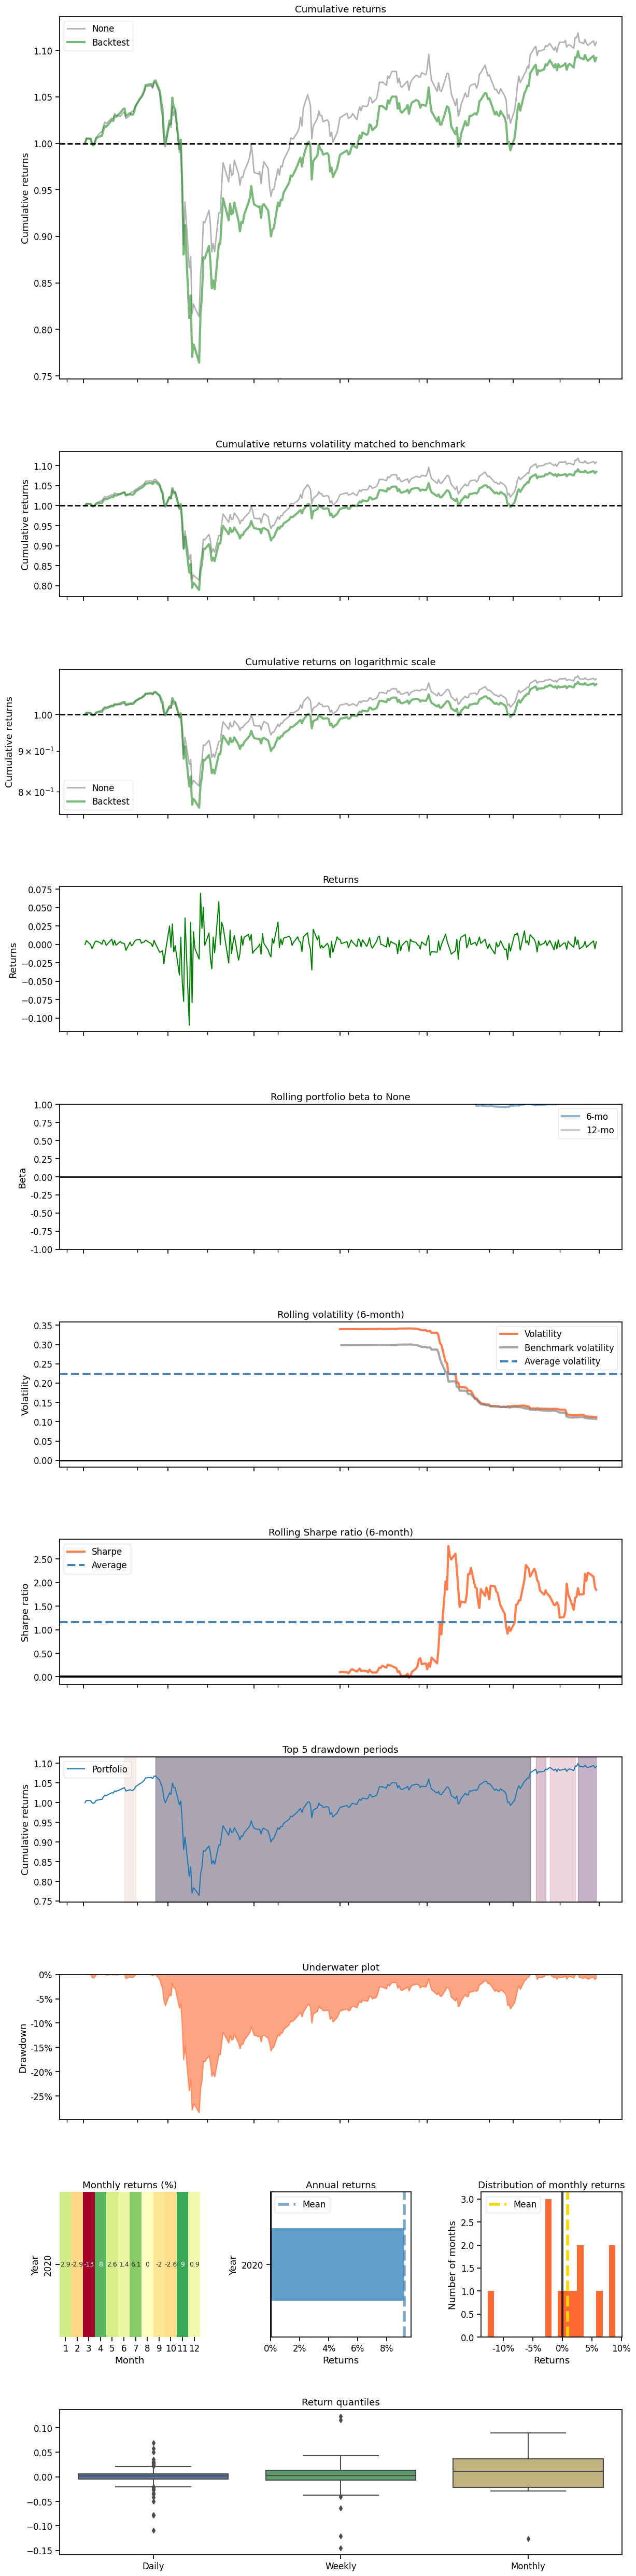

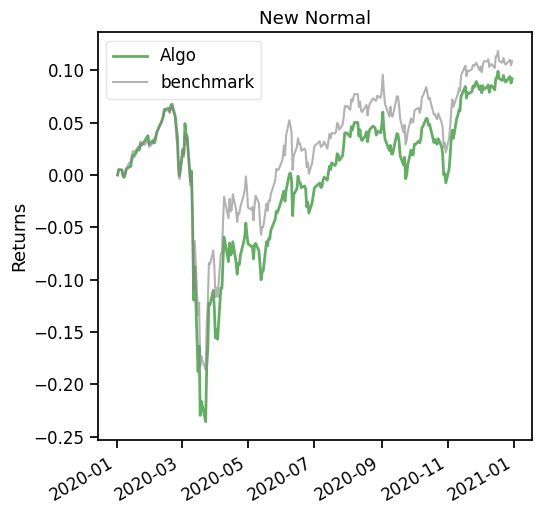

In [11]:
backtestPlot(DRL_returns, equalWeight_returns)

In [12]:
print("==============All In Stock Strategy Stats===========")
all_stock_actions= getTicActions(trade, 'VTI')
df_stock_return, df_stock_value = computeReturns(all_stock_actions,trade)
stock_returns, stock_stats = getStats(df_stock_return)
stock_stats

==============All In Stock Strategy Stats===========


Annual return          0.174385
Cumulative returns     0.174385
Annual volatility      0.342913
Sharpe ratio           0.643331
Calmar ratio           0.498238
Stability              0.417230
Max drawdown          -0.350003
Omega ratio            1.137599
Sortino ratio          0.876570
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.874110
Daily value at risk   -0.042328
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [13]:
print("==============All In Debt Strategy Stats===========")
all_debt_actions= getTicActions(trade, 'TLT')
df_debt_return, df_debt_value = computeReturns(all_debt_actions,trade)
debt_returns, debt_stats = getStats(df_debt_return)
debt_stats

==============All In Debt Strategy Stats===========


Annual return          0.149551
Cumulative returns     0.149551
Annual volatility      0.216263
Sharpe ratio           0.754591
Calmar ratio           0.950877
Stability              0.170797
Max drawdown          -0.157277
Omega ratio            1.158568
Sortino ratio          1.137780
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.057718
Daily value at risk   -0.026599
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [14]:
print("==============All In Reit Strategy Stats===========")
all_reit_actions= getTicActions(trade, 'VNQ')
df_reit_return, df_reit_value = computeReturns(all_reit_actions,trade)
reit_returns, reit_stats = getStats(df_reit_return)
reit_stats

==============All In Reit Strategy Stats===========


Annual return         -0.082661
Cumulative returns    -0.082661
Annual volatility      0.419540
Sharpe ratio           0.008097
Calmar ratio          -0.192933
Stability              0.010442
Max drawdown          -0.428442
Omega ratio            1.001621
Sortino ratio          0.010640
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.953195
Daily value at risk   -0.052844
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [15]:
cumulativeReturnPlot(DRL_returns, equalWeight_returns, minVariance_returns, stock_returns, debt_returns, reit_returns)

In [16]:
weightTrend_plot(df_actions)

In [17]:

df_VTI = load_data('./AI_Trading/data/VTI.csv', 'VTI')
df_VNQ = load_data('./AI_Trading/data/VNQ.csv', 'VNQ')
df_TLT = load_data('./AI_Trading/data/TLT.csv', 'TLT')

In [18]:
cumulativeReturnPlot_ETF(stock_returns, debt_returns, reit_returns)

In [19]:
closePlot_ETF(df_VTI, df_TLT, df_VNQ)

In [20]:
# evaluate multi strategy
base = pd.read_csv('./AI_Trading/results/df_daily_return_base_12.csv', index_col='date')
mdd = pd.read_csv('./AI_Trading/results/df_daily_return_mdd_12.csv', index_col='date')
sharpe = pd.read_csv('./AI_Trading/results/df_daily_return_sharpe_12.csv', index_col='date')
minReturn = pd.read_csv('./AI_Trading/results/df_daily_return_minReturn_12.csv', index_col='date')
cumulativeReturnPlot(base.daily_return, mdd.daily_return, minReturn.daily_return, stock_returns, debt_returns, reit_returns)